# 🎯 Policies: กลยุทธ์การตัดสินใจของ Agent
## เข้าใจ Deterministic, Stochastic, และ Epsilon-Greedy Policies

---

## 📖 เรื่องราว: นักเทรดสามสไตล์

สมมติมีนักเทรด 3 คน ใช้กลยุทธ์ต่างกัน:

### 👤 นักเทรด A: "The Robot" (Deterministic)
```bash
ราคาขึ้น → ซื้อเสมอ (100%)
ราคาลง → ขายเสมอ (100%)
```
- ทำ action เดียวกันทุกครั้งในสถานการณ์เดียวกัน
- **Deterministic Policy**: π(s) → a

---

### 👥 นักเทรด B: "The Strategist" (Stochastic)
```bash
ราคาขึ้น → ซื้อ 70%, รอ 30%
ราคาลง → ขาย 60%, รอ 40%
```
- มีความยืดหยุ่น ไม่ได้ทำเหมือนกันทุกครั้ง
- **Stochastic Policy**: π(a|s) = probability

---

### 🎲 นักเทรด C: "The Explorer" (Epsilon-Greedy)
```bash
90% เวลา → ทำตาม best action
10% เวลา → ลองอะไรใหม่ๆ (random)
```
- ส่วนใหญ่ใช้ความรู้ แต่ยังคงลองของใหม่
- **Epsilon-Greedy Policy**: Balance exploitation & exploration

---

## 🧠 Policy คืออะไร?

**Policy (π)** = กลยุทธ์ที่ Agent ใช้ในการเลือก Action

### ประเภทของ Policy:

#### 1️⃣ Deterministic Policy
```bash
π(s) = a
```
- Input: State s
- Output: Action a (แน่นอน)
- **ตัวอย่าง:**
  - ราคา > MA200 → Buy
  - ราคา < MA200 → Sell

#### 2️⃣ Stochastic Policy
```bash
π(a|s) = P(A_t=a | S_t=s)
```
- Input: State s
- Output: Probability distribution over actions
- **ตัวอย่าง:**
  - ราคา > MA200 → Buy (80%), Hold (20%)
  - ราคา < MA200 → Sell (70%), Hold (30%)

#### 3️⃣ Epsilon-Greedy Policy
```bash
π(s) = {
  argmax_a Q(s,a)  with probability 1-ε (exploit)
  random action    with probability ε   (explore)
}
```
- Balance ระหว่าง exploitation (ใช้ความรู้) และ exploration (ลองของใหม่)

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import pandas as pd

plt.rcParams['font.family'] = 'DejaVu Sans'
sns.set_style('whitegrid')
np.random.seed(42)

print("📦 Libraries loaded!")

📦 Libraries loaded!


## 🎮 Environment: Simple Grid World

เริ่มจาก simple environment เพื่อทดสอบ policies ต่างๆ

In [2]:
class PolicyGridWorld:
    def __init__(self, size=5):
        self.size = size
        self.start_pos = (0, 0)
        self.goal_pos = (size-1, size-1)
        self.holes = [(1, 1), (2, 3), (3, 1)]
        self.actions = ['↑', '↓', '←', '→']
        self.action_effects = {
            '↑': (-1, 0),
            '↓': (1, 0),
            '←': (0, -1),
            '→': (0, 1)
        }
        self.reset()
    
    def reset(self):
        self.pos = self.start_pos
        return self.pos
    
    def step(self, action):
        dr, dc = self.action_effects[action]
        new_pos = (self.pos[0] + dr, self.pos[1] + dc)
        
        # Check boundaries
        if not (0 <= new_pos[0] < self.size and 0 <= new_pos[1] < self.size):
            new_pos = self.pos  # Stay in place
        
        self.pos = new_pos
        
        # Calculate reward
        if self.pos == self.goal_pos:
            reward = 10
            done = True
        elif self.pos in self.holes:
            reward = -10
            done = True
        else:
            reward = -1
            done = False
        
        return self.pos, reward, done
    
    def get_state(self):
        return self.pos

# Create environment
env = PolicyGridWorld(size=5)
print("✅ GridWorld Environment Created!")
print(f"Start: {env.start_pos}, Goal: {env.goal_pos}, Holes: {env.holes}")

✅ GridWorld Environment Created!
Start: (0, 0), Goal: (4, 4), Holes: [(1, 1), (2, 3), (3, 1)]


## 1️⃣ Deterministic Policy

Policy ที่เลือก action แน่นอนสำหรับทุก state

In [3]:
class DeterministicPolicy:
    """Simple deterministic policy: Always go right or down toward goal"""
    def __init__(self, env):
        self.env = env
        self.name = "Deterministic"
    
    def select_action(self, state):
        """Always select action toward goal (greedy toward bottom-right)"""
        r, c = state
        goal_r, goal_c = self.env.goal_pos
        
        # Priority: right > down
        if c < goal_c:
            return '→'
        elif r < goal_r:
            return '↓'
        else:
            return '→'  # Default
    
    def run_episode(self, max_steps=50):
        """Run one episode"""
        state = self.env.reset()
        total_reward = 0
        trajectory = [state]
        
        for step in range(max_steps):
            action = self.select_action(state)
            state, reward, done = self.env.step(action)
            total_reward += reward
            trajectory.append(state)
            
            if done:
                break
        
        return total_reward, trajectory, step + 1

# Test Deterministic Policy
det_policy = DeterministicPolicy(env)
reward, trajectory, steps = det_policy.run_episode()

print("🤖 Deterministic Policy Test:")
print("="*50)
print(f"Total Reward: {reward}")
print(f"Steps: {steps}")
print(f"Trajectory: {trajectory[:10]}...")  # First 10 steps
print("="*50)

# Run multiple episodes
num_episodes = 100
rewards = []
for _ in range(num_episodes):
    r, _, _ = det_policy.run_episode()
    rewards.append(r)

print(f"\n📊 Performance over {num_episodes} episodes:")
print(f"Mean Reward: {np.mean(rewards):.2f}")
print(f"Std Reward: {np.std(rewards):.2f}")
print(f"Success Rate: {(np.array(rewards) > 0).sum() / num_episodes * 100:.1f}%")

🤖 Deterministic Policy Test:
Total Reward: 3
Steps: 8
Trajectory: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 4), (2, 4), (3, 4), (4, 4)]...

📊 Performance over 100 episodes:
Mean Reward: 3.00
Std Reward: 0.00
Success Rate: 100.0%


## 2️⃣ Stochastic Policy

Policy ที่มี probability distribution over actions

In [4]:
class StochasticPolicy:
    """Stochastic policy with probability distribution"""
    def __init__(self, env, main_action_prob=0.7):
        self.env = env
        self.main_action_prob = main_action_prob
        self.name = "Stochastic"
    
    def get_action_probabilities(self, state):
        """Get probability distribution over actions"""
        r, c = state
        goal_r, goal_c = self.env.goal_pos
        
        # Initialize probabilities
        probs = {a: 0.0 for a in self.env.actions}
        
        # Determine preferred action (toward goal)
        if c < goal_c:
            preferred = '→'
        elif r < goal_r:
            preferred = '↓'
        else:
            preferred = '→'
        
        # Assign probabilities
        probs[preferred] = self.main_action_prob
        remaining_prob = 1.0 - self.main_action_prob
        other_actions = [a for a in self.env.actions if a != preferred]
        for action in other_actions:
            probs[action] = remaining_prob / len(other_actions)
        
        return probs
    
    def select_action(self, state):
        """Sample action from probability distribution"""
        probs = self.get_action_probabilities(state)
        actions = list(probs.keys())
        probabilities = list(probs.values())
        return np.random.choice(actions, p=probabilities)
    
    def run_episode(self, max_steps=50):
        """Run one episode"""
        state = self.env.reset()
        total_reward = 0
        trajectory = [state]
        
        for step in range(max_steps):
            action = self.select_action(state)
            state, reward, done = self.env.step(action)
            total_reward += reward
            trajectory.append(state)
            
            if done:
                break
        
        return total_reward, trajectory, step + 1

# Test Stochastic Policy
stoch_policy = StochasticPolicy(env, main_action_prob=0.7)

# Show probability distribution for a state
example_state = (1, 2)
probs = stoch_policy.get_action_probabilities(example_state)
print(f"🎲 Stochastic Policy: Action Probabilities at {example_state}")
print("="*50)
for action, prob in probs.items():
    bar = '█' * int(prob * 50)
    print(f"{action}: {prob:.2f} {bar}")
print("="*50)

# Run multiple episodes
num_episodes = 100
rewards_stoch = []
for _ in range(num_episodes):
    r, _, _ = stoch_policy.run_episode()
    rewards_stoch.append(r)

print(f"\n📊 Performance over {num_episodes} episodes:")
print(f"Mean Reward: {np.mean(rewards_stoch):.2f}")
print(f"Std Reward: {np.std(rewards_stoch):.2f}")
print(f"Success Rate: {(np.array(rewards_stoch) > 0).sum() / num_episodes * 100:.1f}%")

🎲 Stochastic Policy: Action Probabilities at (1, 2)
↑: 0.10 █████
↓: 0.10 █████
←: 0.10 █████
→: 0.70 ███████████████████████████████████

📊 Performance over 100 episodes:
Mean Reward: -7.19
Std Reward: 7.64
Success Rate: 21.0%


## 3️⃣ Epsilon-Greedy Policy

Policy สำหรับ Q-Learning: balance exploitation & exploration

In [5]:
class EpsilonGreedyPolicy:
    """Epsilon-Greedy policy for Q-Learning"""
    def __init__(self, env, epsilon=0.1):
        self.env = env
        self.epsilon = epsilon
        self.name = f"ε-Greedy (ε={epsilon})"
        
        # Mock Q-table (จาก training)
        self.Q = defaultdict(lambda: defaultdict(float))
        self._initialize_q_values()
    
    def _initialize_q_values(self):
        """Initialize Q-values (mock - normally learned)"""
        for r in range(self.env.size):
            for c in range(self.env.size):
                state = (r, c)
                goal_r, goal_c = self.env.goal_pos
                
                # Simple heuristic: actions toward goal have higher Q
                for action in self.env.actions:
                    if action == '→' and c < goal_c:
                        self.Q[state][action] = 5.0
                    elif action == '↓' and r < goal_r:
                        self.Q[state][action] = 5.0
                    else:
                        self.Q[state][action] = 1.0
    
    def select_action(self, state, mode='train'):
        """Select action using epsilon-greedy strategy"""
        if mode == 'train' and np.random.random() < self.epsilon:
            # Explore: random action
            return np.random.choice(self.env.actions)
        else:
            # Exploit: best action
            q_values = self.Q[state]
            max_q = max(q_values.values())
            # Handle ties: random among best actions
            best_actions = [a for a, q in q_values.items() if q == max_q]
            return np.random.choice(best_actions)
    
    def run_episode(self, max_steps=50, mode='train'):
        """Run one episode"""
        state = self.env.reset()
        total_reward = 0
        trajectory = [state]
        exploration_count = 0
        
        for step in range(max_steps):
            # Track if we explored
            if mode == 'train' and np.random.random() < self.epsilon:
                exploration_count += 1
            
            action = self.select_action(state, mode=mode)
            state, reward, done = self.env.step(action)
            total_reward += reward
            trajectory.append(state)
            
            if done:
                break
        
        return total_reward, trajectory, step + 1, exploration_count

# Test Epsilon-Greedy Policy
eg_policy = EpsilonGreedyPolicy(env, epsilon=0.1)

# Show Q-values for a state
example_state = (1, 2)
q_values = eg_policy.Q[example_state]
print(f"🎯 ε-Greedy Policy: Q-values at {example_state}")
print("="*50)
for action, q in q_values.items():
    marker = " ← BEST" if q == max(q_values.values()) else ""
    print(f"Q({action}): {q:.2f}{marker}")
print("="*50)

# Run multiple episodes
num_episodes = 100
rewards_eg = []
exploration_rates = []

for _ in range(num_episodes):
    r, _, steps, explorations = eg_policy.run_episode(mode='train')
    rewards_eg.append(r)
    exploration_rates.append(explorations / steps)

print(f"\n📊 Performance over {num_episodes} episodes:")
print(f"Mean Reward: {np.mean(rewards_eg):.2f}")
print(f"Std Reward: {np.std(rewards_eg):.2f}")
print(f"Success Rate: {(np.array(rewards_eg) > 0).sum() / num_episodes * 100:.1f}%")
print(f"Avg Exploration Rate: {np.mean(exploration_rates) * 100:.1f}%")

🎯 ε-Greedy Policy: Q-values at (1, 2)
Q(↑): 1.00
Q(↓): 5.00 ← BEST
Q(←): 1.00
Q(→): 5.00 ← BEST

📊 Performance over 100 episodes:
Mean Reward: -7.53
Std Reward: 6.70
Success Rate: 29.0%
Avg Exploration Rate: 13.9%


## 📊 เปรียบเทียบ Policies

In [6]:
# Compare all policies
policies = [
    DeterministicPolicy(env),
    StochasticPolicy(env, main_action_prob=0.7),
    EpsilonGreedyPolicy(env, epsilon=0.1),
    EpsilonGreedyPolicy(env, epsilon=0.3)
]

policies[-1].name = "ε-Greedy (ε=0.3)"  # Update name

results = {}
num_episodes = 200

print("🏁 Running Policy Comparison...\n")

for policy in policies:
    rewards = []
    steps_list = []
    
    for _ in range(num_episodes):
        if isinstance(policy, EpsilonGreedyPolicy):
            r, _, s, _ = policy.run_episode(mode='train')
        else:
            r, _, s = policy.run_episode()
        rewards.append(r)
        steps_list.append(s)
    
    results[policy.name] = {
        'rewards': rewards,
        'steps': steps_list,
        'mean_reward': np.mean(rewards),
        'std_reward': np.std(rewards),
        'success_rate': (np.array(rewards) > 0).sum() / num_episodes * 100,
        'mean_steps': np.mean(steps_list)
    }

# Print comparison table
print("📊 Policy Comparison Results:")
print("="*80)
print(f"{'Policy':<20} {'Mean Reward':>12} {'Std':>8} {'Success %':>10} {'Avg Steps':>10}")
print("="*80)
for name, res in results.items():
    print(f"{name:<20} {res['mean_reward']:>12.2f} {res['std_reward']:>8.2f} {res['success_rate']:>9.1f}% {res['mean_steps']:>10.1f}")
print("="*80)

🏁 Running Policy Comparison...

📊 Policy Comparison Results:
Policy                Mean Reward      Std  Success %  Avg Steps
Deterministic                3.00     0.00     100.0%        8.0
Stochastic                  -6.58     8.08      28.5%        9.6
ε-Greedy (ε=0.1)            -8.45     6.36      23.5%        4.3
ε-Greedy (ε=0.3)           -10.15     5.49      10.5%        5.0


C:\Users\NaweeparbW\AppData\Local\Temp\ipykernel_21212\3548895225.py:52: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax4.boxplot(box_data, labels=names, patch_artist=True)


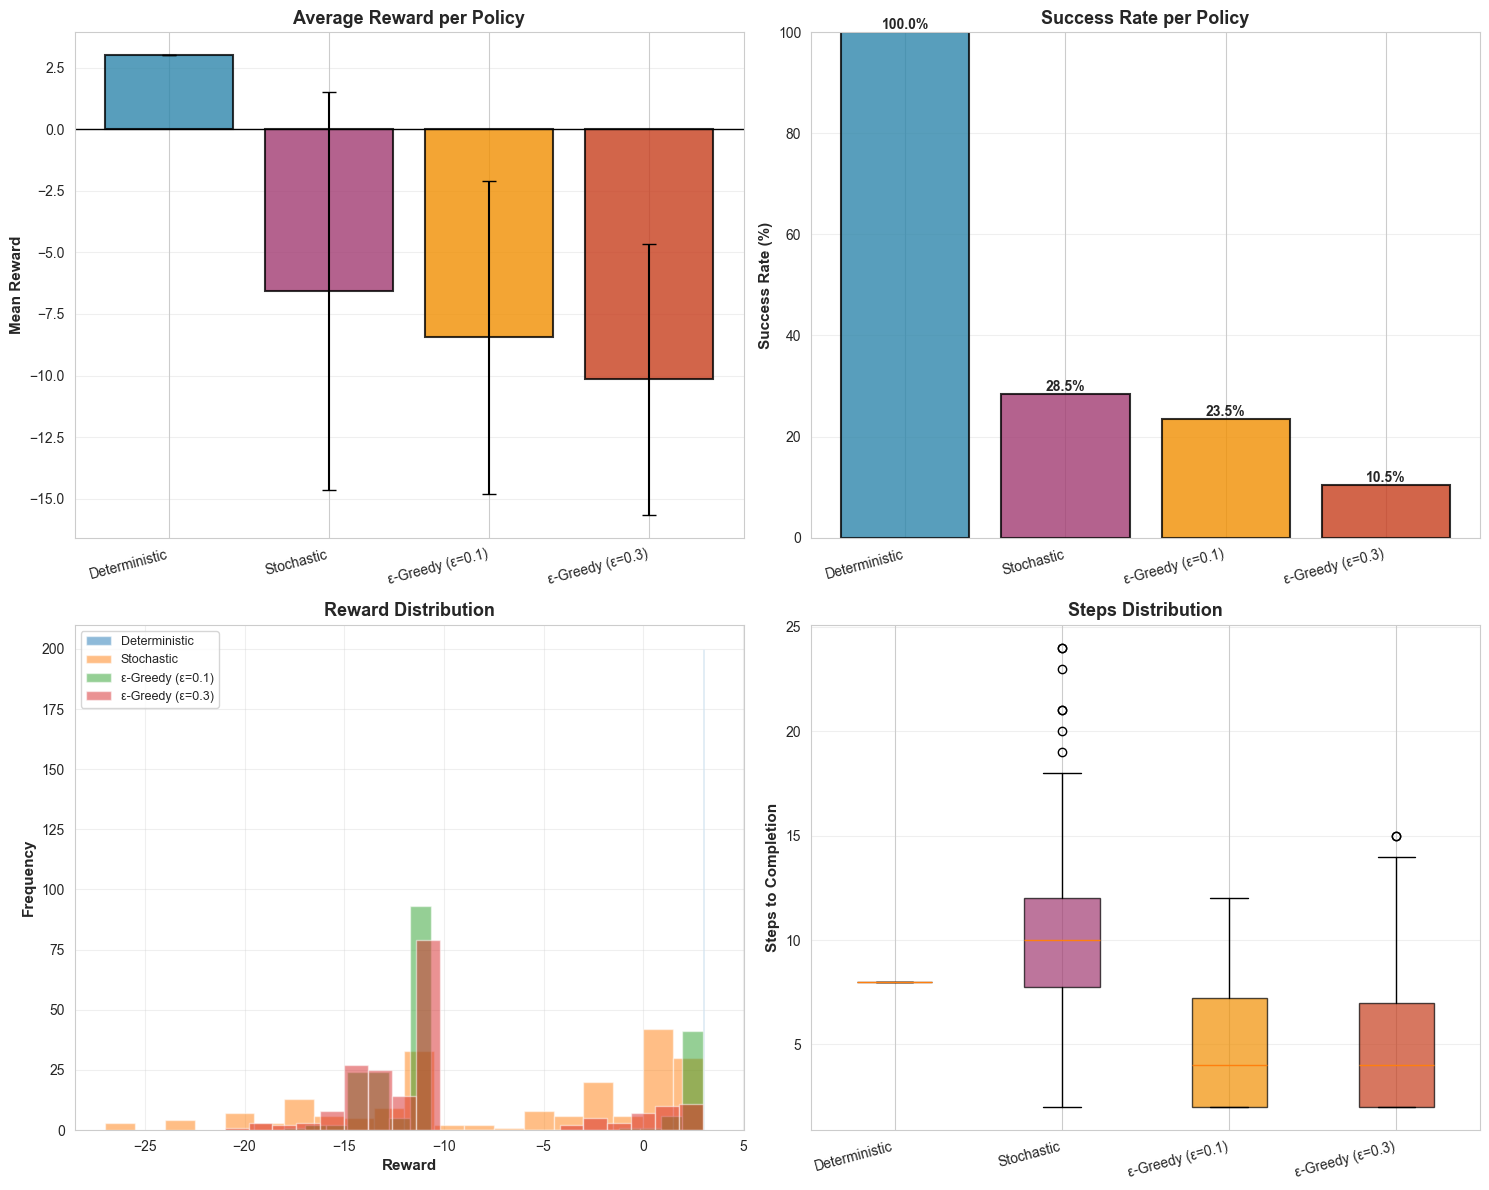


💡 Key Insights:
- Deterministic: Fast but may get stuck
- Stochastic: More exploration, more variability
- ε-Greedy (low ε): Good balance, mostly exploit
- ε-Greedy (high ε): More exploration, slower convergence


In [7]:
# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Mean Reward Comparison
ax1 = axes[0, 0]
names = list(results.keys())
means = [results[n]['mean_reward'] for n in names]
stds = [results[n]['std_reward'] for n in names]

bars = ax1.bar(range(len(names)), means, yerr=stds, capsize=5, 
               color=['#2E86AB', '#A23B72', '#F18F01', '#C73E1D'],
               edgecolor='black', linewidth=1.5, alpha=0.8)
ax1.set_xticks(range(len(names)))
ax1.set_xticklabels(names, rotation=15, ha='right')
ax1.set_ylabel('Mean Reward', fontsize=11, fontweight='bold')
ax1.set_title('Average Reward per Policy', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')
ax1.axhline(y=0, color='black', linestyle='-', linewidth=1)

# 2. Success Rate Comparison
ax2 = axes[0, 1]
success_rates = [results[n]['success_rate'] for n in names]
bars = ax2.bar(range(len(names)), success_rates, 
               color=['#2E86AB', '#A23B72', '#F18F01', '#C73E1D'],
               edgecolor='black', linewidth=1.5, alpha=0.8)
ax2.set_xticks(range(len(names)))
ax2.set_xticklabels(names, rotation=15, ha='right')
ax2.set_ylabel('Success Rate (%)', fontsize=11, fontweight='bold')
ax2.set_title('Success Rate per Policy', fontsize=13, fontweight='bold')
ax2.set_ylim([0, 100])
ax2.grid(True, alpha=0.3, axis='y')

# Add percentage labels
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 3. Reward Distribution
ax3 = axes[1, 0]
for name in names:
    ax3.hist(results[name]['rewards'], bins=20, alpha=0.5, label=name)
ax3.set_xlabel('Reward', fontsize=11, fontweight='bold')
ax3.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax3.set_title('Reward Distribution', fontsize=13, fontweight='bold')
ax3.legend(loc='upper left', fontsize=9)
ax3.grid(True, alpha=0.3)

# 4. Steps Distribution
ax4 = axes[1, 1]
box_data = [results[n]['steps'] for n in names]
bp = ax4.boxplot(box_data, labels=names, patch_artist=True)
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax4.set_xticklabels(names, rotation=15, ha='right')
ax4.set_ylabel('Steps to Completion', fontsize=11, fontweight='bold')
ax4.set_title('Steps Distribution', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n💡 Key Insights:")
print("- Deterministic: Fast but may get stuck")
print("- Stochastic: More exploration, more variability")
print("- ε-Greedy (low ε): Good balance, mostly exploit")
print("- ε-Greedy (high ε): More exploration, slower convergence")

## 🎛️ Effect of Epsilon (ε)

มาดูว่า epsilon ส่งผลต่อ performance อย่างไร

🎛️ Testing Different Epsilon Values...

ε = 0.00: Mean Reward =  -9.25, Success =  20.0%
ε = 0.05: Mean Reward =  -9.12, Success =  20.0%
ε = 0.10: Mean Reward =  -8.66, Success =  20.0%
ε = 0.20: Mean Reward = -10.08, Success =  15.0%
ε = 0.30: Mean Reward = -10.66, Success =  10.0%
ε = 0.50: Mean Reward = -12.03, Success =   3.0%


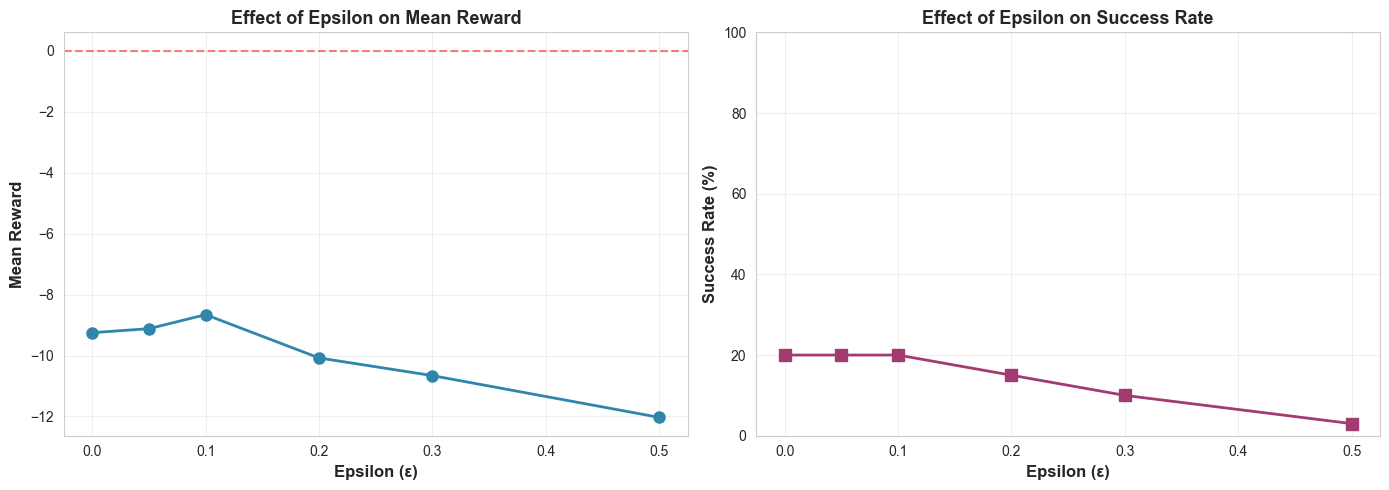


💡 Interpretation:
- ε = 0: Pure exploitation (no exploration) → อาจ stuck ใน local optima
- ε ต่ำ (0.05-0.1): Good balance สำหรับ testing
- ε ปานกลาง (0.2-0.3): เหมาะสำหรับ training ช่วงแรก
- ε สูง (0.5+): Random มากเกินไป, performance ลดลง


In [8]:
# Test different epsilon values
epsilon_values = [0.0, 0.05, 0.1, 0.2, 0.3, 0.5]
epsilon_results = {}

print("🎛️ Testing Different Epsilon Values...\n")

for eps in epsilon_values:
    policy = EpsilonGreedyPolicy(env, epsilon=eps)
    rewards = []
    
    for _ in range(100):
        r, _, _, _ = policy.run_episode(mode='train')
        rewards.append(r)
    
    epsilon_results[eps] = {
        'mean_reward': np.mean(rewards),
        'success_rate': (np.array(rewards) > 0).sum() / 100 * 100
    }
    
    print(f"ε = {eps:.2f}: Mean Reward = {np.mean(rewards):6.2f}, Success = {epsilon_results[eps]['success_rate']:5.1f}%")

# Plot epsilon effect
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Mean Reward vs Epsilon
eps_list = list(epsilon_results.keys())
mean_rewards = [epsilon_results[e]['mean_reward'] for e in eps_list]
ax1.plot(eps_list, mean_rewards, marker='o', linewidth=2, markersize=8, color='#2E86AB')
ax1.set_xlabel('Epsilon (ε)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Mean Reward', fontsize=12, fontweight='bold')
ax1.set_title('Effect of Epsilon on Mean Reward', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='red', linestyle='--', alpha=0.5)

# Success Rate vs Epsilon
success_rates_eps = [epsilon_results[e]['success_rate'] for e in eps_list]
ax2.plot(eps_list, success_rates_eps, marker='s', linewidth=2, markersize=8, color='#A23B72')
ax2.set_xlabel('Epsilon (ε)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Success Rate (%)', fontsize=12, fontweight='bold')
ax2.set_title('Effect of Epsilon on Success Rate', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 100])

plt.tight_layout()
plt.show()

print("\n💡 Interpretation:")
print("- ε = 0: Pure exploitation (no exploration) → อาจ stuck ใน local optima")
print("- ε ต่ำ (0.05-0.1): Good balance สำหรับ testing")
print("- ε ปานกลาง (0.2-0.3): เหมาะสำหรับ training ช่วงแรก")
print("- ε สูง (0.5+): Random มากเกินไป, performance ลดลง")

## 💹 Trading Policy Example

มาดูตัวอย่าง policy ใน trading context

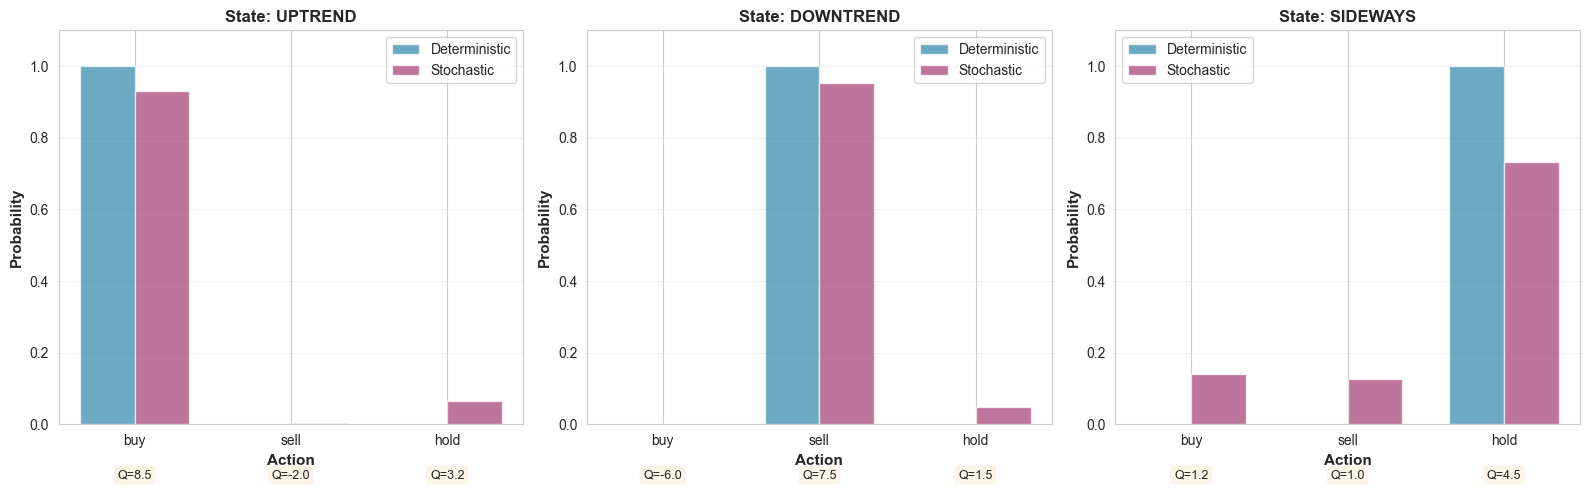

💹 Trading Policy Insights:

UPTREND:
  Deterministic → buy (always)
  Stochastic → buy (92.9% of time)
  Q-values: {'buy': 8.5, 'sell': -2.0, 'hold': 3.2}

DOWNTREND:
  Deterministic → sell (always)
  Stochastic → sell (95.2% of time)
  Q-values: {'buy': -6.0, 'sell': 7.5, 'hold': 1.5}

SIDEWAYS:
  Deterministic → hold (always)
  Stochastic → hold (73.2% of time)
  Q-values: {'buy': 1.2, 'sell': 1.0, 'hold': 4.5}


In [9]:
class TradingPolicyComparison:
    """Compare different trading policies"""
    def __init__(self):
        self.states = ['uptrend', 'downtrend', 'sideways']
        self.actions = ['buy', 'sell', 'hold']
        
        # Mock Q-values from training
        self.Q = {
            'uptrend': {'buy': 8.5, 'sell': -2.0, 'hold': 3.2},
            'downtrend': {'buy': -6.0, 'sell': 7.5, 'hold': 1.5},
            'sideways': {'buy': 1.2, 'sell': 1.0, 'hold': 4.5}
        }
    
    def deterministic_policy(self, state):
        """Always pick best action"""
        return max(self.Q[state], key=self.Q[state].get)
    
    def stochastic_policy(self, state, temperature=1.0):
        """Softmax policy"""
        q_values = np.array(list(self.Q[state].values()))
        exp_q = np.exp(q_values / temperature)
        probs = exp_q / exp_q.sum()
        return dict(zip(self.actions, probs))
    
    def epsilon_greedy_policy(self, state, epsilon=0.1):
        """Epsilon-greedy"""
        if np.random.random() < epsilon:
            return np.random.choice(self.actions)
        else:
            return max(self.Q[state], key=self.Q[state].get)
    
    def visualize_policies(self):
        """Visualize action selection for different policies"""
        fig, axes = plt.subplots(1, 3, figsize=(16, 5))
        
        for idx, state in enumerate(self.states):
            ax = axes[idx]
            
            # Deterministic
            det_action = self.deterministic_policy(state)
            det_probs = {a: 1.0 if a == det_action else 0.0 for a in self.actions}
            
            # Stochastic (softmax)
            stoch_probs = self.stochastic_policy(state, temperature=2.0)
            
            # Plot
            x = np.arange(len(self.actions))
            width = 0.35
            
            bars1 = ax.bar(x - width/2, [det_probs[a] for a in self.actions], 
                          width, label='Deterministic', color='#2E86AB', alpha=0.7)
            bars2 = ax.bar(x + width/2, [stoch_probs[a] for a in self.actions], 
                          width, label='Stochastic', color='#A23B72', alpha=0.7)
            
            ax.set_xlabel('Action', fontsize=11, fontweight='bold')
            ax.set_ylabel('Probability', fontsize=11, fontweight='bold')
            ax.set_title(f'State: {state.upper()}', fontsize=12, fontweight='bold')
            ax.set_xticks(x)
            ax.set_xticklabels(self.actions)
            ax.legend(fontsize=10)
            ax.set_ylim([0, 1.1])
            ax.grid(True, alpha=0.3, axis='y')
            
            # Add Q-values as text
            for i, action in enumerate(self.actions):
                q = self.Q[state][action]
                ax.text(i, -0.15, f'Q={q:.1f}', ha='center', fontsize=9, 
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
        
        plt.tight_layout()
        plt.show()

# Create and visualize
trading_comp = TradingPolicyComparison()
trading_comp.visualize_policies()

print("💹 Trading Policy Insights:")
print("="*60)
for state in trading_comp.states:
    det = trading_comp.deterministic_policy(state)
    stoch = trading_comp.stochastic_policy(state, temperature=2.0)
    print(f"\n{state.upper()}:")
    print(f"  Deterministic → {det} (always)")
    print(f"  Stochastic → {max(stoch, key=stoch.get)} ({max(stoch.values())*100:.1f}% of time)")
    print(f"  Q-values: {trading_comp.Q[state]}")
print("="*60)

## 🎓 สรุป: Policies

### 📌 Deterministic Policy
- **π(s) = a** (แน่นอน)
- **ข้อดี:**
  - ง่าย, เร็ว
  - Reproducible
  - เหมาะสำหรับ deployment
- **ข้อเสีย:**
  - ไม่มี exploration
  - อาจติด local optima
- **Use case:** Production trading bot (หลัง training เสร็จ)

---

### 📌 Stochastic Policy
- **π(a|s) = probability**
- **ข้อดี:**
  - Natural exploration
  - ยืดหยุ่น
  - เหมาะสำหรับ continuous actions
- **ข้อเสีย:**
  - Variance สูงกว่า
  - ยากต่อการ debug
- **Use case:** Policy Gradient methods (PPO, A2C)

---

### 📌 Epsilon-Greedy Policy
- **π(s) = best action (1-ε), random (ε)**
- **ข้อดี:**
  - Balance exploration/exploitation
  - Simple และ effective
  - ใช้กับ Q-Learning ได้ดี
- **ข้อเสีย:**
  - ε ต้องปรับ (decay)
  - Exploration แบบ uniform (ไม่ smart)
- **Use case:** Q-Learning, DQN training

---

## 🎯 การเลือก Policy สำหรับ Trading

### ช่วง Training:
- ใช้ **ε-Greedy** หรือ **Stochastic**
- ε เริ่มสูง (0.3-0.5) แล้ว decay ลง (0.05-0.1)
- เพื่อ explore strategies ต่างๆ

### ช่วง Testing/Backtesting:
- ใช้ **Deterministic** (greedy)
- ε = 0 (pure exploitation)
- เพื่อดู true performance

### Production:
- ใช้ **Deterministic** เกือบตลอด
- อาจมี ε เล็กมาก (0.01) เพื่อ adaptability

---

## 🚀 Next Steps:

1. **Notebook 05:** Exploration vs Exploitation Deep Dive
2. **Chapter 02:** Q-Learning Basics

---

## 💪 แบบฝึกหัด

### Exercise 1: Implement Softmax Policy
สร้าง stochastic policy โดยใช้ softmax:
```python
π(a|s) = exp(Q(s,a)/τ) / Σ exp(Q(s,a')/τ)
```
ทดสอบกับ temperature τ = 0.5, 1.0, 2.0

### Exercise 2: Epsilon Decay Schedule
สร้าง epsilon decay schedule:
- Linear decay: ε = ε_start - (ε_start - ε_end) * (episode / max_episodes)
- Exponential decay: ε = ε_end + (ε_start - ε_end) * exp(-decay_rate * episode)

เปรียบเทียบ performance

### Exercise 3: Trading Policy Design
ออกแบบ policy สำหรับ crypto trading:
- States: (trend, volume, position)
- Actions: buy, sell, hold
- ทดสอบทั้ง 3 policy types
- วิเคราะห์ว่า policy ไหนเหมาะสมที่สุด

---

**🎯 Ready for the final notebook?**

👉 [Next: 05_exploration_exploitation.ipynb](05_exploration_exploitation.ipynb)